# Clever filtering using pytorch Module and optimizer

I didn't have good luck using my own gradient descent so I'm using this as an opportunity to learn the higher level pytorch mechanisms like `torch.nn`. This [tutorial on pytorch](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) is very good.

## Support code

In [1]:
import math
import torch
dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def RF_valid(df, movie_embeddings, user_embeddings):
    X = df[['movieId','userId']]
    y = df['rating']
    X_emb = np.concatenate([movie_embeddings[X['movieId']],user_embeddings[X['userId']]], axis=1)

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X_emb, y)
    print(f"OOB R^2 {rf.oob_score_:.3f}")
    print(f"Train R^2 {rf.score(X_emb, y):.3f}")

In [3]:
import pandas as pd
import re

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    # Merge in the title and genres
    df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
    df = df_ratings.merge(df_movies, on='movieId')
    # Strip the "(1999)" dates from the titles
    p = re.compile(r'[()0-9]+$')
    df['title'] = df['title'].map(lambda x: p.sub('', x).strip())
    return df

def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    df[colname] = df[colname].cat.codes # encode 0..n-1  NB: Different than I usually do (1..n)!!!!
    df[colname] = df[colname].astype(int)
    
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2, device, dtype, mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [4]:
def mae(y_pred, y):
    return torch.mean( (y_pred - y).abs() )

In [5]:
def train_test_split(data, test_size:float):
    n = len(data)
    n_valid = int(n*test_size)
    n_train = n - n_valid
    indices = torch.randperm(n)
    train_idx = indices[0:n_train]
    test_idx = indices[n_train:]
    train, test = data[train_idx], data[test_idx] # copying data but could not get columns out of a Subset object
    # train, valid = data, data
    X_train = train[:,[0,1]].float()
    X_test = test[:,[0,1]].float()
    y_train = train[:,2].float()
    y_test = test[:,2].float()
    return X_train, X_test, y_train, y_test

In [6]:
def top_movies(df, n=100):
    rating_count = df.groupby('movieId')['rating'].count()
    top_movieIds = rating_count.sort_values(ascending=False).index.values[:n]

    df_top = df[df['movieId'].isin(top_movieIds)][['movieId','title','genres']].drop_duplicates()
    return df_top

In [7]:
import matplotlib.pyplot as plt
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Rating (0..5.0) MAE")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

In [8]:
from sklearn.decomposition import PCA

def mcolor(genre):
    if 'Comedy' in genre: return 'green'
    if 'Sci-Fi' in genre: return 'cyan'
    if 'War' in genre: return 'red'
    if 'Drama' in genre: return '#FEE08F'
    return 'black'

def plot_comedy_drama_embeddings(df, movie_embeddings, n=1000, xrange=(-1,1), yrange=(-1,1)):
#    df_movies = df[(df['genres'].str.contains('Comedy'))|(df['genres'].str.contains('Drama'))]
#     df_movies = top_movies(df_movies, n)
    df_movies = top_movies(df, n)
    movie_embeddings = movie_embeddings[df_movies['movieId'].values]
    
    plt.figure(figsize=(5,5))
    movieIds = df_movies['movieId'].values
    genres = df_movies['genres'].values
    titles = df_movies['title'].values
    pca = PCA(n_components=2)
    vecs2D = pca.fit_transform(movie_embeddings)
    c = [mcolor(genres[i]) for i in range(len(vecs2D))]
    plt.scatter(vecs2D[:,0], vecs2D[:,1], c=c, s=5, alpha=.5)
    plt.xlim(*xrange)
    plt.ylim(*yrange)
    plt.show()
    return df_movies, vecs2D

In [9]:
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

output_notebook() # send to notebook not tab

def plot_bokeh_comend_drama_embeddings(df_movies, vecs2D):
    data = dict(
        x=vecs2D[:,0],
        y=vecs2D[:,1],
        title = df_movies['title'],
        genre = df_movies['genres'],
        colors = [mcolor(df_movies['genres'].iloc[i]) for i in range(len(vecs2D))]
    )
    source = ColumnDataSource(data)
    fig = figure(plot_width=500, plot_height=300,
                 title='Movie embeddings projected with PCA',
                 tools='pan,wheel_zoom,zoom_in,box_zoom,reset,hover',
                 x_axis_type=None, y_axis_type=None, min_border=1)
    fig.scatter(x='x', y='y',source=source, fill_alpha=0.7, size=5, fill_color='colors')
    # hover tools,
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips = {'content': '@title'}
    show(fig)

Loading BokehJS ...

## Load and train with no mini-batch

In [75]:
df = load(n=100_000)
n = len(df)
nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')
df.head(2)

,userId,movieId,rating,title,genres
0,598,4692,2.0,Project X,Comedy|Drama
1,473,4692,3.5,Project X,Comedy|Drama


In [76]:
avg_rating = np.mean(df['rating'])
avg_rating

3.50172

In [77]:
import torch.nn as nn

class CollabFilter(nn.Module):
    def __init__(self, nusers, nmovies, nfactors=10, avg_rating=3.5):
        super(CollabFilter, self).__init__()
        self.U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.U = nn.Parameter(self.U) # notify pytorch these are model parameters
        self.M = nn.Parameter(self.M)
        
    def forward(self, x):
        userIds = x[:,0].long()
        movieIds = x[:,1].long()
        r_output = (self.U[userIds] * self.M[movieIds]).sum(axis=1, keepdim=False)
        r_output = torch.sigmoid(r_output) * 5  # limit to 0..5
        return r_output

In [161]:
def train(df, epochs=350, nfactors=10, use_bias=False, print_every=30):
    data = torch.tensor( df[['userId','movieId','rating']].values )
    X_train, X_valid, y_train, y_valid = train_test_split(data, 0.20)
    print(f"{len(X_train)} training and {len(X_valid)} test records")

    if use_bias:
        model = CollabFilterWithBias(nusers, nmovies, nfactors=nfactors)
    else:
        model = CollabFilter(nusers, nmovies, nfactors=nfactors)
    loss_fn = torch.nn.MSELoss()

    learning_rate = 0.002
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00000002) # model.parameters is just [U,M]

    history = []

    # Start history with what random weights show
    with torch.no_grad():
        loss = loss_fn(model(X_train), y_train)
        loss_valid = loss_fn(model(X_valid), y_valid)
        mae_train = mae(model(X_train), y_train).detach().item()
        mae_valid = mae(model(X_valid), y_valid).detach().item()
    history.append( (loss, loss_valid) )
    print(f"Init      L2 MSE loss {loss:4.3f}, {loss_valid:4.3f}   MAE {mae_train:4.3f}, {mae_valid:4.3f}")

    for t in range(epochs):
        r_pred = model(X_train)
        loss = loss_fn(r_pred, y_train)

        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad and M.grad
        optimizer.step()

        with torch.no_grad():
            loss_valid = loss_fn(model(X_valid), y_valid)
            mae_train = mae(model(X_train), y_train).detach().item()
            mae_valid = mae(model(X_valid), y_valid).detach().item()

        history.append( (loss, loss_valid) )
        if t % print_every == 0:
            print(f"Epoch {t:3d} L2 MSE loss {loss:4.3f}, {loss_valid:4.3f}   MAE {mae_train:4.3f}, {mae_valid:4.3f}")

    history = torch.tensor(history)
    return model, history

80000 training and 20000 test records
Init      L2 MSE loss 2.928, 2.856   MAE 1.393, 1.376
Epoch   0 L2 MSE loss 2.928, 2.847   MAE 1.391, 1.374
Epoch  30 L2 MSE loss 2.571, 2.495   MAE 1.286, 1.271
Epoch  60 L2 MSE loss 2.026, 1.966   MAE 1.105, 1.095
Epoch  90 L2 MSE loss 1.446, 1.423   MAE 0.898, 0.898
Epoch 120 L2 MSE loss 1.066, 1.084   MAE 0.769, 0.784
Epoch 150 L2 MSE loss 0.878, 0.926   MAE 0.706, 0.733
Epoch 180 L2 MSE loss 0.783, 0.851   MAE 0.670, 0.706
Epoch 210 L2 MSE loss 0.730, 0.812   MAE 0.645, 0.689
Epoch 240 L2 MSE loss 0.697, 0.792   MAE 0.630, 0.680
Epoch 270 L2 MSE loss 0.676, 0.782   MAE 0.620, 0.675
Epoch 300 L2 MSE loss 0.663, 0.778   MAE 0.614, 0.674
Epoch 330 L2 MSE loss 0.654, 0.777   MAE 0.610, 0.674


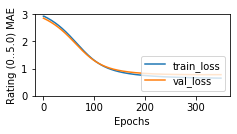

In [162]:
model, history = train(df, epochs=350, nfactors=10)
plot_history(history, yrange=(0,3), figsize=(3.5,1.5))

## Interpretation

### Using embeddings for prediction with random forest

Once we have embeddings, we can try to use them as features in a random forest. The OOB error will give us an indication of how good the embeddings are. When we get a validation MAE of 0.74 from training with n=20,000 and nfactors=10, the RF OOB R^2 is about .45, which is much better than we get using label encoded categorical variables (no better than guessing the mean with about R^2 of 0.0).

In [79]:
RF_valid(df, model.M.detach().cpu(), model.U.detach().cpu())

OOB R^2 0.389
Train R^2 0.916


In [80]:
model, history = train(df, epochs=350, nfactors=4, print_every=50)
RF_valid(df, model.M.detach().cpu(), model.U.detach().cpu())

80000 training and 20000 test records
Init      L2 MSE loss 2.927, 2.867   MAE 1.393, 1.378
Epoch   0 L2 MSE loss 2.927, 2.861   MAE 1.392, 1.377
Epoch  50 L2 MSE loss 2.539, 2.479   MAE 1.278, 1.264
Epoch 100 L2 MSE loss 1.933, 1.893   MAE 1.079, 1.071
Epoch 150 L2 MSE loss 1.345, 1.343   MAE 0.857, 0.861
Epoch 200 L2 MSE loss 1.006, 1.038   MAE 0.751, 0.767
Epoch 250 L2 MSE loss 0.846, 0.901   MAE 0.694, 0.722
Epoch 300 L2 MSE loss 0.764, 0.835   MAE 0.661, 0.698
OOB R^2 0.348
Train R^2 0.911


In [81]:
model, history = train(df, epochs=350, nfactors=50, print_every=50)
RF_valid(df, model.M.detach().cpu(), model.U.detach().cpu())

80000 training and 20000 test records
Init      L2 MSE loss 2.912, 2.921   MAE 1.389, 1.393
Epoch   0 L2 MSE loss 2.912, 2.901   MAE 1.384, 1.387
Epoch  50 L2 MSE loss 1.183, 1.215   MAE 0.799, 0.823
Epoch 100 L2 MSE loss 0.709, 0.818   MAE 0.636, 0.690
Epoch 150 L2 MSE loss 0.648, 0.794   MAE 0.607, 0.680
Epoch 200 L2 MSE loss 0.631, 0.800   MAE 0.598, 0.683
Epoch 250 L2 MSE loss 0.616, 0.805   MAE 0.589, 0.685
Epoch 300 L2 MSE loss 0.582, 0.808   MAE 0.571, 0.687
OOB R^2 0.492
Train R^2 0.930


## Compare rating vs predicted rating visually

If we plot the known ratings against the predicted ratings, ideally we would see a 45° line. If true rating is 4.0 then we'd want the predicted rating to be 4.0.

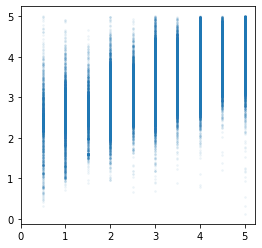

In [84]:
data = torch.tensor( df[['userId','movieId','rating']].values )
plt.figure(figsize=(4.2,4))
plt.scatter(model(data).detach().cpu(), df['rating'], alpha=.05, s=3)
plt.xticks(range(6))
plt.yticks(range(6))
plt.show()

Hmm...hard to interpret, let's try a joint plot!

80000 training and 20000 test records
Init      L2 MSE loss 2.916, 2.906   MAE 1.391, 1.388
Epoch   0 L2 MSE loss 2.916, 2.886   MAE 1.385, 1.382
Epoch  50 L2 MSE loss 1.185, 1.207   MAE 0.800, 0.819
Epoch 100 L2 MSE loss 0.709, 0.814   MAE 0.636, 0.690
Epoch 150 L2 MSE loss 0.649, 0.788   MAE 0.607, 0.680
Epoch 200 L2 MSE loss 0.632, 0.793   MAE 0.598, 0.682
Epoch 250 L2 MSE loss 0.617, 0.799   MAE 0.589, 0.685
Epoch 300 L2 MSE loss 0.581, 0.802   MAE 0.571, 0.687


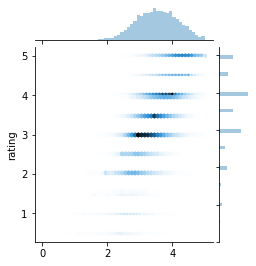

In [101]:
# I learned this jointplot trick from https://github.com/fastai/fastai/blob/master/courses/dl1/lesson5-movielens.ipynb
import seaborn

model, history = train(df, epochs=350, nfactors=50, print_every=50)
seaborn.jointplot(model(data).detach().cpu(), df['rating'], kind='hex', height=3.8)
plt.xticks(range(6))
plt.yticks(range(6))
plt.show()

80000 training and 20000 test records
Init      L2 MSE loss 2.904, 2.952   MAE 1.388, 1.398
Epoch   0 L2 MSE loss 2.904, 2.943   MAE 1.386, 1.395
Epoch  50 L2 MSE loss 2.204, 2.242   MAE 1.167, 1.182
Epoch 100 L2 MSE loss 1.278, 1.344   MAE 0.826, 0.857
Epoch 150 L2 MSE loss 0.868, 0.968   MAE 0.702, 0.747
Epoch 200 L2 MSE loss 0.737, 0.856   MAE 0.649, 0.705
Epoch 250 L2 MSE loss 0.682, 0.816   MAE 0.623, 0.688
Epoch 300 L2 MSE loss 0.657, 0.803   MAE 0.611, 0.683


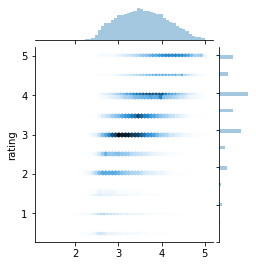

In [100]:
model, history = train(df, epochs=350, nfactors=10, print_every=50)
seaborn.jointplot(model(data).detach().cpu(), df['rating'], kind='hex', height=3.8)
plt.xticks(range(6))
plt.yticks(range(6))
plt.show()

It looks to me like the embedding with 50 dimensions gets a tighter mapping (45° line) than 10 dimensional embedding vectors.

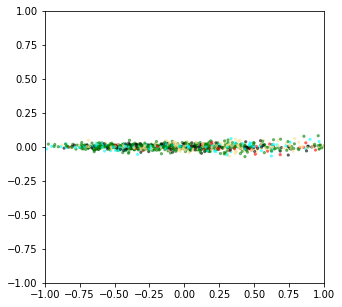

In [13]:
df_movies, vecs2D = plot_comedy_drama_embeddings(df, M.cpu().detach().numpy(), n=1000)#, xrange=(-3,3), yrange=(-3,3))

In [14]:
plot_bokeh_comend_drama_embeddings(df_movies, vecs2D)

## Model with biases

In [146]:
import torch.nn as nn

class CollabFilterWithBias(nn.Module):
    def __init__(self, nusers, nmovies, nfactors=10, avg_rating=3.5):
        super(CollabFilterWithBias, self).__init__()
        self.U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.U_bias = randn(nusers,  1,        device=device, dtype=dtype, requires_grad=True,
                      std=0.01, mean=avg_rating/nfactors)
        self.M_bias = randn(nmovies, 1,        device=device, dtype=dtype, requires_grad=True,
                      std=0.01, mean=avg_rating/nfactors)
        self.U = nn.Parameter(self.U) # notify pytorch these are model parameters
        self.M = nn.Parameter(self.M)
        self.U_bias = nn.Parameter(self.U_bias)
        self.M_bias = nn.Parameter(self.M_bias)
        
    def forward(self, x):
        userIds = x[:,0].long()
        movieIds = x[:,1].long()
        r_output = (self.U[userIds] * self.M[movieIds]).sum(axis=1)
        bias = (self.U_bias[userIds] + self.M_bias[movieIds]).reshape(len(x))
        r_output = r_output
        r_output += bias
        r_output = torch.sigmoid(r_output) * 5  # limit to 0..5
        return r_output

80000 training and 20000 test records
Init      L2 MSE loss 2.972, 2.936   MAE 1.405, 1.398
Epoch   0 L2 MSE loss 2.972, 2.917   MAE 1.400, 1.393
Epoch  50 L2 MSE loss 1.109, 1.128   MAE 0.783, 0.804
Epoch 100 L2 MSE loss 0.659, 0.790   MAE 0.614, 0.681
Epoch 150 L2 MSE loss 0.614, 0.778   MAE 0.591, 0.675
Epoch 200 L2 MSE loss 0.598, 0.780   MAE 0.582, 0.675
Epoch 250 L2 MSE loss 0.580, 0.780   MAE 0.572, 0.674
Epoch 300 L2 MSE loss 0.541, 0.779   MAE 0.551, 0.674
Epoch 350 L2 MSE loss 0.462, 0.779   MAE 0.506, 0.675


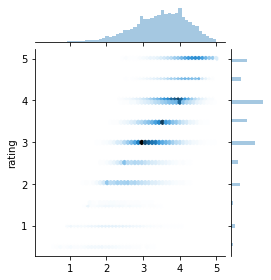

In [163]:
model, history = train(df, epochs=400, nfactors=50, use_bias=True, print_every=50)
g = seaborn.jointplot(model(data).detach().cpu(), df['rating'], kind='hex', height=4)
plt.show()

Another trick from fastai book is to look at biases

In [200]:
df_movies = top_movies(df, n=100_000)
df_movies = df_movies.set_index('movieId')

In [201]:
df_movies.head(10)

,title,genres
movieId,,
4692,Project X,Comedy|Drama
510,"Silence of the Lambs, The",Crime|Horror|Thriller
5487,Hair,Comedy|Drama|Musical
3897,Austin Powers in Goldmember,Comedy
706,2001: A Space Odyssey,Adventure|Drama|Sci-Fi
551,James and the Giant Peach,Adventure|Animation|Children|Fantasy|Musical
5964,Thumbsucker,Comedy|Drama
2353,Toy Story 2,Adventure|Animation|Children|Comedy|Fantasy
5321,Mask,Drama


In [212]:
len(df_movies), model.M_bias.shape

(9702, torch.Size([9702, 1]))

In [215]:
movie_bias = model.M_bias.squeeze()
idxs = movie_bias.argsort()
print("Most negative biases:",movie_bias[idxs][:10])

Most negative biases: tensor([-0.6630, -0.6368, -0.6300, -0.6183, -0.6114, -0.6046, -0.6016, -0.5862,
        -0.5850, -0.5753], grad_fn=<SliceBackward>)


In [214]:
df_movies.loc[idxs,'title'].head(10)

Biases: tensor([-0.6630, -0.6368, -0.6300, -0.6183, -0.6114, -0.6046, -0.6016, -0.5862,
        -0.5850, -0.5753], grad_fn=<SliceBackward>)


movieId
667                                            Relic, The
7247                                            Room, The
4673                                        Hard Way, The
2680                                         Center Stage
5611                   Batman Beyond: Return of the Joker
1331                                     Newton Boys, The
683                                            Funny Face
2864                                          Phantasm II
5844    Ivan's Childhood (a.k.a. My Name is Ivan) (Iva...
9068                                           Unforgiven
Name: title, dtype: object

In [216]:
movie_bias = model.M_bias.squeeze()
idxs = movie_bias.argsort(descending=True)
print("Most postive biases:",movie_bias[idxs][:10])
df_movies.loc[idxs,'title'].head(10)

Most postive biases: tensor([0.9593, 0.9503, 0.9427, 0.8923, 0.8700, 0.8622, 0.8598, 0.8571, 0.8532,
        0.8521], grad_fn=<SliceBackward>)


movieId
9135                                   World of Tomorrow
6027    Match Factory Girl, The (Tulitikkutehtaan tyttö)
4580                         Come and See (Idi i smotri)
4037                            Galaxy of Terror (Quest)
8900                                 Big Top Scooby-Doo!
8972                          Hollywood Chainsaw Hookers
8926                                             Villain
9033                                          The Editor
8306                                   Hunting Elephants
7605                  My Life as McDull (Mak dau goo si)
Name: title, dtype: object

The fastai book points out quite nicely that movies with very negative biases mean that people don't like them, even when the movie x user dot product gives the movie a high score (a high score indicates they are likely to enjoy that movie based on the latent features).  For the really positive bias movies, such as 0.9593 bias, that indicates that even if the movie is not a good fit for you, you might like it because it gives you almost a full star boost because it is that good. Of course, it is also the case that poorly matched movies with low bias predicts a really bad experience watching the movie.  Naturally we should recommend to people movies that have both high product and high bias.